## User Feature Extraction

In [1]:
import pandas as pd 
import time
import pickle
from collections import defaultdict

# first_block = 400040
# last_block = 400045

with open('../pickles/ml/train_blocks', 'rb') as f:
    block_list = pickle.load(f)

class User:
    def __init__(self, adrs, txs):
        self.adr = set(adrs)
        self.sending_tx = set(txs)
        self.cadr = set()
        self.receiving_tx = set(txs)
        
#Read Users found
with open('../pickles/pool/all_users.pickle', 'rb') as f:
    users = pickle.load(f)
df = pd.read_pickle('../pickles/pool/all_df_with_users.pickle')

# #Read Users found
# with open('../pickles/pool/all_users.pickle', 'rb') as f:
#     users = pickle.load(f)
# df = pd.read_pickle('../pickles/pool/all_df_with_users.pickle')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
# user input features
user_input_df = df.groupby('input_user').agg({
    'id_txo_out': 'nunique', #Num unique times paid out
    'oadr':'nunique', #Num of unique out addresses paid out
    'output_user': 'nunique', #Num of unique users paid out (Out Degree)
    #'id_txi': 'nunique', #Num unique times paid in
    'id_t': 'nunique', #Num Txs involved in
    'input_val': ['max', 'min']
})

user_input_df.columns = ['_'.join(col) for col in user_input_df.columns]

user_input_df.rename(columns={
    'id_txo_out_nunique': 'unique_sent',
    'oadr_nunique': 'unique_sent_adr',
    'output_user_nunique': 'unique_sent_user',  # (Out Degree)
    'id_t_nunique': 'num_sending_tx',
    'input_val_max': 'max_sent',
    'input_val_min': 'min_sent'
}, inplace=True)

user_input_df['total_sent'] = (df['input_val'] / df['num_txo']).groupby(df['input_user']).sum()
#dummy1 = (df['input_val'] / df['num_txo']).groupby(df['input_user']).sum()
#dummy2 = (df['output_val'] / df['num_txi']).groupby(df['input_user']).sum()

# user output features
user_out_df = df.groupby('output_user').agg({
    'id_txi': 'nunique', #Num unique times paid in
    'iadr': 'nunique', #Num of unique in addresses paid this user
    'input_user': 'nunique', #Num of unique users paid in (In Degree)
    #'id_txo_out': 'nunique', #Num unique times paid
    'id_t': 'nunique', #Num Txs involved in
    'output_val': ['max', 'min']
})

user_out_df.columns = ['_'.join(col) for col in user_out_df.columns]

user_out_df.rename(columns={
    'id_txi_nunique': 'unique_rec',
    'iadr_nunique': 'unique_rec_adr',
    'input_user_nunique': 'unique_rec_user',  # (In Degree)
    'id_t_nunique': '',
    'output_val_max': 'max_rec',
    'output_val_min': 'min_rec'
}, inplace=True)

user_out_df['total_rec'] = (df['output_val'] / df['num_txi']).groupby(df['output_user']).sum()

# Merge input and output user features
user_df = user_input_df.merge(user_out_df, how='outer', left_index=True, right_index=True)
user_df = user_df.iloc[:len(users)]

# Name index
user_df.index.name = 'user'

# New columns
user_df['num_tx'] = user_df['num_sending_tx'] + user_df['num_receiving_tx']
# user_df = user_df.drop(['tx1', 'tx2'], axis=1)

temp = df.groupby('output_user').agg({
    'iadr': lambda x: (x == '0').any(), #Num of unique in addresses paid this user
})
temp.rename(columns={
    'iadr': 'is_miner',
}, inplace=True)
# Name index
#temp.index.name = 'user'
user_df['is_miner'] = temp['is_miner'].iloc[:len(users)]

# Fill in NA values
user_df['is_miner'].fillna(False, inplace=True)
user_df.fillna(0, inplace=True)

user_df.is_miner = user_df.is_miner.apply(lambda x: 1 if x == True else 0)


#Add column to indicate labelled users
user_df["category"] = "unknown"

user_total_sent = [(user,total_rec) for (user, total_rec) in user_df['total_sent'].iteritems()]
#users_identified = list(user_df.index.values) 

# Totals
total_amt_spent = (df['input_val'] / df['num_txo']).sum() ##Total amount spent in this block?
total_amt_recieved = (df['output_val'] / df['num_txi']).sum() ##Total amount received in this block?

user_df = user_df.sort_index()

## Tag Users with data from walletexplorer.com

In [8]:
#Dictionary structure - 
#'Address': 'Category'
categories = ['exchanges','gambling','pool']
dic_userlabels = defaultdict(set)
starttime = time.time() 


for category in categories:
    #for block in range(first_block,last_block+1,1):
    for block in block_list:
        category_df = pd.read_pickle('../pickles/categories/{}.pickle'.format(category))
        addr = category_df.loc[category_df['last used in block'] == block]['address'].tolist()
        if(len(addr)!=0):
            for a in addr:
                dic_userlabels[a].add(category)
print("Total time to dict:", time.time()-starttime)


Total time to dict: 67.83587074279785


In [9]:
user_label = defaultdict(set)
# label = {}
# label[categories[0]]=1
# label[categories[1]]=2
for i, user in enumerate(users):
    labels = set()
    for key in dic_userlabels:
        if key in user.adr:
            cat = dic_userlabels[key]
            user_df.loc[i, 'category'] = list(cat)[0] #label[cat.pop()]
            labels.add(list(cat)[0])
    if labels:
        user_label[i].update(labels)       

In [35]:
_blocks = [len(_user.blocks) for _user in users]
_num_adr = [len(_user.adr) for _user in users]

user_df['num_blocks_active'] = _blocks
user_df['num_adr'] = _num_adr

user_df[['unique_sent_user_b','unique_sent_b', 'unique_sent_adr_b', 'num_sending_tx_b', 'total_sent_b', 'unique_rec_b', 'num_receiving_tx_b', 'unique_rec_user_b', 'unique_rec_adr_b', 'total_rec_b', 'num_tx_b']] = user_df[['unique_sent_user','unique_sent', 'unique_sent_adr', 'num_sending_tx', 'total_sent', 'unique_rec', 'num_receiving_tx', 'unique_rec_user', 'unique_rec_adr', 'total_rec', 'num_tx']].div(_blocks, axis=0)



#user_df_normalized = user_df.copy()
# user_df_normalized['num_blocks_active'] = _blocks
# user_df_normalized['num_adr'] = _num_adr

# user_df_normalized[['unique_sent_user_b','unique_sent_b', 'unique_sent_adr_b', 'num_sending_tx_b', 'total_sent_b', 'unique_rec_b', 'num_receiving_tx_b', 'unique_rec_user_b', 'unique_rec_adr_b', 'total_rec_b', 'num_tx_b']] = user_df_normalized[['unique_sent_user','unique_sent', 'unique_sent_adr', 'num_sending_tx', 'total_sent', 'unique_rec', 'num_receiving_tx', 'unique_rec_user', 'unique_rec_adr', 'total_rec', 'num_tx']].div(_blocks, axis=0)

## Data Exploration

In [36]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
import imblearn

In [37]:
data_correlation = user_df.corr(method='spearman')
print("correlation: ")
data_correlation.style.format("{:.2}").background_gradient(cmap=plt.cm.Greens, axis=1)

correlation: 


,num_sending_tx,max_sent,min_sent,unique_sent,unique_sent_adr,unique_sent_user,total_sent,unique_rec_user,num_receiving_tx,unique_rec,max_rec,min_rec,unique_rec_adr,total_rec,num_tx,is_miner,num_blocks_active,num_adr,unique_sent_user_b,unique_sent_b,unique_sent_adr_b,num_sending_tx_b,total_sent_b,unique_rec_b,num_receiving_tx_b,unique_rec_user_b,unique_rec_adr_b,total_rec_b,num_tx_b
num_sending_tx,1.0,0.014,-0.067,0.48,0.4,0.22,0.065,0.15,0.37,0.29,0.092,0.0058,0.1,0.12,0.42,-0.07,0.6,0.03,0.054,0.38,0.19,0.88,0.041,0.24,0.3,0.048,0.042,0.11,0.35
max_sent,0.014,1.0,0.8,0.11,0.11,0.19,0.99,0.082,0.078,-0.054,0.59,0.54,0.022,0.59,0.077,-0.03,0.012,-0.12,0.19,0.11,0.11,0.021,0.99,-0.054,0.08,0.082,0.024,0.59,0.08
min_sent,-0.067,0.8,1.0,-0.041,-0.035,0.034,0.78,0.079,0.065,-0.17,0.57,0.57,-0.056,0.57,0.061,-0.03,-0.074,-0.33,0.055,-0.026,-0.01,-0.044,0.79,-0.17,0.074,0.094,-0.047,0.57,0.072
unique_sent,0.48,0.11,-0.041,1.0,0.98,0.81,0.13,0.02,0.13,0.098,0.016,-0.045,0.026,0.032,0.15,-0.037,0.29,0.13,0.73,0.97,0.88,0.43,0.12,0.074,0.098,-0.033,-0.0047,0.025,0.12
unique_sent_adr,0.4,0.11,-0.035,0.98,1.0,0.84,0.13,0.0076,0.1,0.077,0.011,-0.046,0.021,0.025,0.12,-0.037,0.26,0.14,0.76,0.95,0.92,0.35,0.12,0.056,0.074,-0.039,-0.0066,0.018,0.09
unique_sent_user,0.22,0.19,0.034,0.81,0.84,1.0,0.2,-0.067,-0.019,-0.034,-0.011,-0.012,-0.014,-0.0082,-0.004,-0.035,0.14,0.039,0.95,0.81,0.8,0.2,0.2,-0.044,-0.031,-0.092,-0.028,-0.012,-0.019
total_sent,0.065,0.99,0.78,0.13,0.13,0.2,1.0,0.09,0.097,-0.023,0.59,0.54,0.052,0.59,0.099,-0.03,0.046,-0.057,0.19,0.14,0.13,0.069,1.0,-0.025,0.097,0.084,0.05,0.59,0.099
unique_rec_user,0.15,0.082,0.079,0.02,0.0076,-0.067,0.09,1.0,0.96,0.85,0.69,0.61,0.86,0.69,0.95,0.0063,0.11,0.18,-0.096,0.0029,-0.025,0.14,0.085,0.86,0.97,0.98,0.86,0.69,0.96
num_receiving_tx,0.37,0.078,0.065,0.13,0.1,-0.019,0.097,0.96,1.0,0.88,0.67,0.58,0.82,0.68,0.99,0.018,0.23,0.17,-0.08,0.093,0.024,0.33,0.087,0.86,0.99,0.92,0.8,0.68,0.99
unique_rec,0.29,-0.054,-0.17,0.098,0.077,-0.034,-0.023,0.85,0.88,1.0,0.5,0.43,0.87,0.51,0.87,0.0096,0.19,0.29,-0.084,0.069,0.015,0.26,-0.031,0.99,0.87,0.82,0.85,0.51,0.87


In [38]:
data_correlation[(abs(data_correlation) > 0.8) & ( data_correlation != 1.0)].dropna(how="all", axis=(0,1))

/homes/ac2917/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.


,num_sending_tx,max_sent,min_sent,unique_sent,unique_sent_adr,unique_sent_user,total_sent,unique_rec_user,num_receiving_tx,unique_rec,...,unique_sent_b,unique_sent_adr_b,num_sending_tx_b,total_sent_b,unique_rec_b,num_receiving_tx_b,unique_rec_user_b,unique_rec_adr_b,total_rec_b,num_tx_b
num_sending_tx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.877984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_sent,NaN,NaN,0.803376,NaN,NaN,NaN,0.986731,NaN,NaN,NaN,...,NaN,NaN,NaN,0.987338,NaN,NaN,NaN,NaN,NaN,NaN
min_sent,NaN,0.803376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_sent,NaN,NaN,NaN,NaN,0.977190,0.813917,NaN,NaN,NaN,NaN,...,0.969169,0.883701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_sent_adr,NaN,NaN,NaN,0.977190,NaN,0.836733,NaN,NaN,NaN,NaN,...,0.953690,0.915673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_sent_user,NaN,NaN,NaN,0.813917,0.836733,NaN,NaN,NaN,NaN,NaN,...,0.814726,0.804946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_sent,NaN,0.986731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.999017,NaN,NaN,NaN,NaN,NaN,NaN
unique_rec_user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.959403,0.854376,...,NaN,NaN,NaN,NaN,0.856272,0.965720,0.980570,0.856731,NaN,0.955843
num_receiving_tx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.959403,NaN,0.876530,...,NaN,NaN,NaN,NaN,0.864885,0.989218,0.917751,NaN,NaN,0.985008
unique_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.854376,0.876530,NaN,...,NaN,NaN,NaN,NaN,0.993984,0.869539,0.821243,0.854387,NaN,0.866479


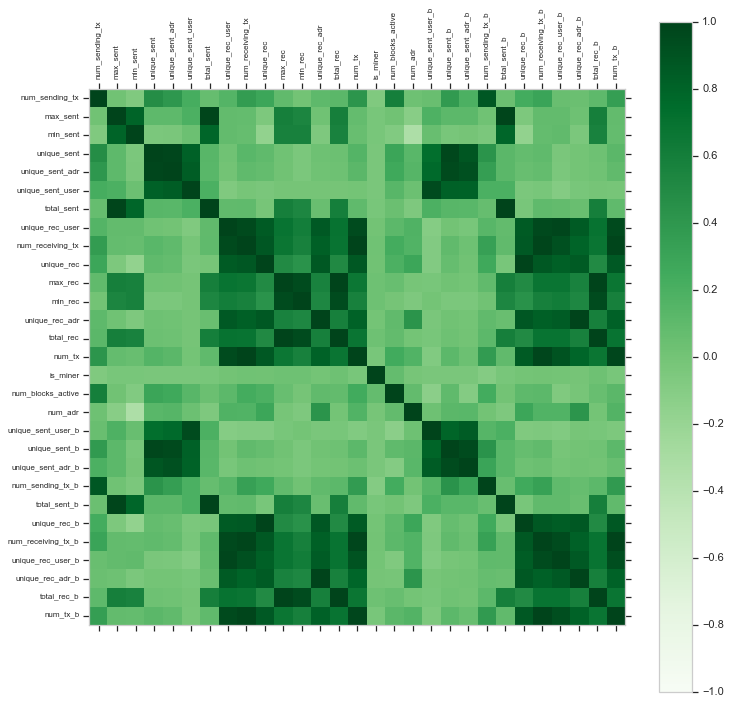

In [39]:
indices = data_correlation.index
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(data_correlation, vmin=-1, vmax=1, cmap=plt.cm.Greens)
fig.colorbar(cax)
ticks = np.arange(0,len(indices),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(indices, fontsize=8)
ax.set_yticklabels(indices, fontsize=8)
plt.grid()
plt.savefig("correlation_matrix.pdf")

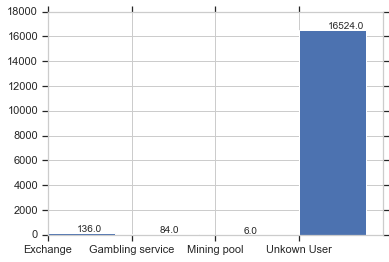

In [41]:
# imbalanced dataset! - factor of ~10
exchanges = np.sum(user_df["category"] == 'exchanges') # or just sum over column, bc its binary
gambling = np.sum(user_df["category"] == 'gambling') # or just sum over column, bc its binary
pool = np.sum(user_df["category"] == 'pool')
unknown = np.sum(user_df["category"] == 'unknown')

fig, ax = plt.subplots()
exchanges, gambling, pool,unknown = plt.bar((0,1,2,3), (exchanges, gambling, pool,unknown))
gambling.set_facecolor('dimgray')
pool.set_facecolor('lightgray')
ax.set_xticks((0,1,2,3))
for p in (ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.34, p.get_height() +100), fontsize=10)
ax.set_xticklabels(['Exchange', 'Gambling service', 'Mining pool', 'Unkown User'])

In [42]:
median_by_category = user_df.groupby(by="category").median()
mean_by_category = user_df.groupby(by="category").mean()
most_rel_diff_median = (median_by_category.diff().iloc[1])/(median_by_category.max()+1e-7) # get the once that differ relatively the most
most_rel_diff_median = most_rel_diff_median[abs(most_rel_diff_median) > 0.04].sort_values(ascending=False)
rel_max = median_by_category[most_rel_diff_median.index.values]/median_by_category[most_rel_diff_median.index.values].max().max()

In [43]:
mean_by_category

,num_sending_tx,max_sent,min_sent,unique_sent,unique_sent_adr,unique_sent_user,total_sent,unique_rec_user,num_receiving_tx,unique_rec,...,unique_sent_b,unique_sent_adr_b,num_sending_tx_b,total_sent_b,unique_rec_b,num_receiving_tx_b,unique_rec_user_b,unique_rec_adr_b,total_rec_b,num_tx_b
category,,,,,,,,,,,,,,,,,,,,,
exchanges,3.830882,42.128641,30.152772,10.154412,7.536765,6.602941,110.969334,2.654412,5.338235,15.161765,...,4.947917,4.715748,1.280208,44.449067,4.578431,1.338879,1.080147,4.050276,16.930891,2.236734
gambling,1.297619,0.155076,0.008475,2.761905,2.630952,2.404762,0.372868,1.011905,1.309524,6.595238,...,2.539683,2.416667,1.176587,0.267193,4.831349,1.059524,0.843254,4.180556,0.043012,1.950397
pool,24.500000,26.182033,0.227076,58.666667,35.333333,26.333333,7235.689572,32.833333,44.500000,1331.500000,...,32.574074,26.277778,7.064815,1017.559180,75.935185,3.962963,3.314815,58.111111,5.575244,10.861111
unknown,1.179618,38.475364,36.818824,3.102457,2.788187,2.598765,53.073773,0.912975,1.086238,3.293634,...,2.763803,2.621220,1.089375,50.055712,2.449330,0.977216,0.880390,2.139765,43.129405,1.803146


In [44]:
median_by_category

,num_sending_tx,max_sent,min_sent,unique_sent,unique_sent_adr,unique_sent_user,total_sent,unique_rec_user,num_receiving_tx,unique_rec,...,unique_sent_b,unique_sent_adr_b,num_sending_tx_b,total_sent_b,unique_rec_b,num_receiving_tx_b,unique_rec_user_b,unique_rec_adr_b,total_rec_b,num_tx_b
category,,,,,,,,,,,,,,,,,,,,,
exchanges,1.0,0.643912,0.010000,2.0,2.0,2.0,1.279604,1.0,1.0,2.0,...,2.000000,2.0,1.000000,1.279604,2.000000,1.0,1.0,1.75,0.010359,2.0
gambling,1.0,0.012900,0.001231,2.0,2.0,2.0,0.030546,1.0,1.0,3.0,...,2.000000,2.0,1.000000,0.030546,2.166667,1.0,1.0,2.00,0.010006,2.0
pool,10.5,25.869100,0.002263,12.5,1.0,1.0,1071.357618,2.5,2.5,2.5,...,10.472222,1.0,5.944444,824.422277,2.500000,2.5,2.5,2.50,1.145465,12.0
unknown,1.0,0.419458,0.140723,2.0,2.0,2.0,0.566295,1.0,1.0,1.0,...,2.000000,2.0,1.000000,0.554582,1.000000,1.0,1.0,1.00,0.078198,2.0


In [ ]:
N = rel_max.shape[1]
GamblingMedian = rel_max.iloc[0].values
PoolMedian = rel_max.iloc[1].values
UnknownMedian = rel_max.iloc[2].values
ind = np.arange(N)    

fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(N)
bar_width = 0.35

opacity = 1

ax.bar(index, GamblingMedian, bar_width, alpha=opacity,
                color='#1F936D', label='Users that are gambling services')


ax.bar(index + bar_width, PoolMedian, bar_width, alpha=opacity,
                color='#36D588', label='Users that are pooling services')


ax.plot((most_rel_diff_median.values), color="r", linestyle="--", label = "relative difference")

# annotate line chart
for i,j in enumerate((most_rel_diff_median.values)):
    ax.annotate(str(np.round(j,2)),xy=(i,j+0.01), fontsize=12)
    
# annotate bar chart
len_median_by_category = len(median_by_category[most_rel_diff_median.index.values].iloc[0])
for i,p in enumerate(ax.patches):
    if i < len_median_by_category:
        c_bar_value = int(median_by_category[most_rel_diff_median.index.values].iloc[0][i])
    else: 
        c_bar_value = int(median_by_category[most_rel_diff_median.index.values].iloc[1][i-len_median_by_category])
    ax.annotate(str(c_bar_value), (p.get_x(), p.get_height() * 1.005), fontsize=12)


ax.set_ylabel('Percentage')
ax.set_title('Relative difference')
ax.set_xticks(index + bar_width / 2)
plt.xticks(rotation=90)

ax.set_xticklabels(rel_max.columns)
ax.legend()

fig.tight_layout()
plt.show()

## Prepare train and test set via downsampling

In [ ]:
train_unknown = user_df[user_df["category"] == 'unknown']#.drop(columns=["category"])
train_gambling = user_df[user_df["category"] == 'gambling']#.drop(columns=["category"])
train_pool = user_df[user_df["category"] == 'pool']#.drop(columns=["category"])

# balance the dataset: 
indices1 = np.arange(train_unknown.shape[0])
#indices2 = np.arange(train_gambling.shape[0])
random_indices1 = np.random.choice(indices1, size = 300)
#random_indices2 = np.random.choice(indices2, size = train_pool.shape[0])
train_unknown = train_unknown.iloc[random_indices1] # choose random staying customers
X_train_downsampled = pd.concat((pd.concat((train_gambling,train_unknown)),train_pool))

from sklearn.preprocessing import LabelEncoder 
X_train_downsampled = X_train_downsampled[~X_train_downsampled.index.duplicated(keep='first')]
cats = X_train_downsampled.category
X_train_downsampled = X_train_downsampled.drop(columns=["category"])
y_train_downsampled = LabelEncoder().fit_transform(cats)

X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(X_train_downsampled, y_train_downsampled)

In [ ]:
x_unknown = user_df[user_df["category"] == 'unknown'].drop(columns=["category"])
y_result = dec_tree_classifier.predict(x_unknown)
y_actual = LabelEncoder().fit_transform(user_df[user_df["category"] == 'unknown'].category)

In [ ]:
accuracy_score(y_result, y_actual)

In [ ]:
print("balanced churn set: ")
# imbalanced dataset! - factor of ~10
gambling = np.sum(cats == 'gambling') # or just sum over column, bc its binary
pool = np.sum(cats == 'pool')
unknown = np.sum(cats == 'unknown')

fig, ax = plt.subplots()
gambling, pool,unknown = plt.bar((0,1,2), (gambling, pool, unknown))
gambling.set_facecolor('dimgray')
pool.set_facecolor('lightgray')
ax.set_xticks((0,1,2))

ax.set_xticklabels(['Gambling', 'Pool', 'Unkown'])
ax.set_ylabel('Number of users')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, filename): 
    plt.figure()
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
    plt.ylabel('true label'),
    plt.xlabel('predicted label')
    plt.savefig(filename+".pdf")
    plt.figure()
    mat_normalized = mat / mat.sum(axis=1)
    sns.heatmap(mat_normalized, fmt="f", square=True, annot=True, cmap="YlGnBu", cbar=True)
    plt.ylabel('true label'),
    plt.xlabel('predicted label')
    print("confusion matrix normalized: ")
    plt.savefig(filename+"_normalized.pdf")

## Prepare train and test set via upsampling 

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
train_unknown = user_df[user_df["category"] == 0].drop(columns=["category"])
train_gambling = user_df[user_df["category"] == 1].drop(columns=["category"])

In [ ]:
X_unbalanced = np.concatenate((train_unknown, train_gambling))

In [ ]:
y_unbalanced = np.concatenate((np.zeros(train_unknown.shape[0]),np.ones(train_gambling.shape[0])))

In [ ]:
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_unbalanced, y_unbalanced)

In [ ]:
n_not_service_in_upsampled_train = np.sum(y_train_upsampled == 0)
n_service_in_upsampled_train = np.sum(y_train_upsampled == 1)

In [ ]:
X_train_upsampled, y_train_upsampled = SMOTE(random_state=42, ratio={0:n_not_service_in_upsampled_train, 1:n_not_service_in_upsampled_train}).fit_sample(X_train_upsampled, y_train_upsampled)

In [ ]:
n_not_service_in_upsampled_test = np.sum(y_test_upsampled == 0)

In [ ]:
X_test_upsampled, y_test_upsampled = SMOTE(random_state=42, ratio={0:n_not_service_in_upsampled_test, 1:n_not_service_in_upsampled_test}).fit_sample(X_test_upsampled, y_test_upsampled)n_staying_in_upsampled_test

## Decision tree on downsampled data

In [ ]:
from sklearn import tree
import pydot
from sklearn.metrics import recall_score, precision_score

In [ ]:
def get_best_dec_tree(X_train,y_train,X_test, y_test):
    best_acc = 0
    best_depth = 0
    for i in range(3,20):
        dec_tree = tree.DecisionTreeClassifier(max_depth = i, random_state=42)
        dec_tree = dec_tree.fit(X_train, y_train)
        y_pred = dec_tree.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        if acc_score > best_acc: 
            best_acc = acc_score
            best_depth = i
    dec_tree = tree.DecisionTreeClassifier(max_depth = best_depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    y_pred = dec_tree.predict(X_test)
    print("the accuracy = " + str(accuracy_score(y_test, y_pred)))
    return dec_tree, y_pred

def plot_dec_tree(decision_tree, feature_names, filename):
    dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                feature_names=feature_names,
                                filled=True,
                                rounded=True) 
    graph = pydot.graph_from_dot_data(dot_data)
    graph[0].write_png(filename+".png")

In [ ]:
dec_tree_classifier, y_pred = get_best_dec_tree(X_train=X_train_downsampled, y_train=y_train_downsampled,
                                       X_test=X_test_downsampled, y_test=y_test_downsampled)

In [ ]:
print("saving confusion matrix for decision tree...")
plot_confusion_matrix(y_test_downsampled, y_pred, "decision_tree_downsampled_conf_matrix")

In [ ]:
dec_tree_classifier.predict()

In [ ]:
plot_dec_tree(dec_tree_classifier, feature_names=X_train_downsampled.columns, filename="decision_tree_downsampled")

In [ ]:
print("Accuracy score: ", accuracy_score(y_test_downsampled, y_pred))

In [ ]:
recall_score(y_test_downsampled, y_pred)

In [ ]:
precision_score(y_test_downsampled, y_pred)

## Decision tree on upsampled data: 


In [ ]:
dec_tree_classifier, y_pred = get_best_dec_tree(X_train=X_train_upsampled, y_train=y_train_upsampled,
                                       X_test=X_test_upsampled, y_test=y_test_upsampled)

In [ ]:
len(y_test_upsampled)

In [ ]:
print("saving confusion matrix for decision tree...")
plot_confusion_matrix(y_test_upsampled, y_pred, "decision_tree_upsampled_conf_matrix")

In [ ]:
print("Accuracy score: ", accuracy_score(y_test_upsampled, y_pred))
print("Recall: ", recall_score(y_test_upsampled, y_pred))
print("Precision: ", precision_score(y_test_upsampled, y_pred))

In [ ]:
print("save decision tree with few depth layers for visualization: ")
dec_tree = tree.DecisionTreeClassifier(max_depth = 4, random_state=42)
dec_tree = dec_tree.fit(X_train_upsampled, y_train_upsampled)
y_pred = dec_tree.predict(X_test_upsampled)
print(accuracy_score(y_test_upsampled, y_pred))

In [ ]:
plot_dec_tree(dec_tree_classifier, feature_names=X_train_downsampled.columns, filename="decision_tree_upsampled")

## Normalize data

In [ ]:
#Normalize data
Y = pd.DataFrame(user_df['category'])
user_df_x = user_df.drop(['category'], axis=1)
scaler = sklearn.preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(user_df_x), columns=user_df_x.columns, index=user_df_x.index)

#Correlation
data_corr = user_df_x.corr()
sns.heatmap(data_corr, cmap = 'bwr') #heatmap of correlation matrix